In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Advanced_Data_Augmentation"
!pwd

/content/drive/MyDrive/Advanced_Data_Augmentation
/content/drive/MyDrive/Advanced_Data_Augmentation


In [3]:
import models
from utils import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

import Solai_Nature as sn
import Helpers as hp
from PIL import Image
!pip install cifar2png

In [4]:
#!/usr/bin/env python3 -u
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree.
from __future__ import print_function

import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import cv2 as cv2

#import sys  
#sys.path.insert(0, '/content/gdrive/MyDrive/Advanced_Data_Augmentation')




# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# parser.add_argument('--model', default="ResNet18", type=str,
#                     help='model type (default: ResNet18)')
# parser.add_argument('--name', default='0', type=str, help='name of run')
# parser.add_argument('--seed', default=0, type=int, help='random seed')
# parser.add_argument('--batch-size', default=128, type=int, help='batch size')
# parser.add_argument('--epoch', default=200, type=int,
#                     help='total epochs to run')
# parser.add_argument('--no-augment', dest='augment', action='store_false',
#                     help='use standard augmentation (default: True)')
# parser.add_argument('--decay', default=1e-4, type=float, help='weight decay')
# parser.add_argument('--alpha', default=1., type=float,
#                     help='mixup interpolation coefficient (default: 1)')
# args = parser.parse_args()

params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "mixup-128-NormalAdvsTrain",
    "seed": 10,
    "batch_size": 128,
    "decay": 5e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 0.,
}

# %cd ../../

In [5]:
use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if params["seed"] != 0:
    torch.manual_seed(params["seed"])

# Data
print('==> Preparing data..')
if params["augment"]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    print("no augmentation")
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=False,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=params["batch_size"],
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='./data', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

==> Preparing data..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
img_arr=trainset[11][0].numpy()
img_arr=np.transpose(img_arr, (1, 2, 0))
a_min=img_arr.reshape(-1).min()
a_max=img_arr.reshape(-1).max()
a_shape=img_arr.shape
a=((img_arr.reshape(-1)-a_min)/(a_max-a_min))*255
a=a.reshape(a_shape)
b=a.astype('uint8')

In [7]:
test=sn.augment_random(b, aug_types=['random_brightness'], volume="expand")

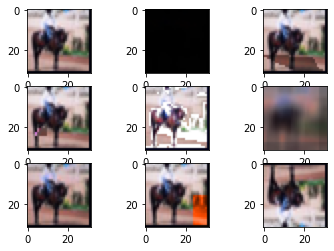

In [8]:
aug_images= sn.augment_random(b, aug_types=['random_brightness','add_shadow','add_gravel','add_snow','add_rain','random_brightness','add_autumn','random_flip'], volume='expand')  ##all aug_types are applied in both images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(b)
axarr[0,1].imshow(aug_images[0])
axarr[0,2].imshow(aug_images[1])
axarr[1,0].imshow(aug_images[2])
axarr[1,1].imshow(aug_images[3])
axarr[1,2].imshow(aug_images[4])
axarr[2,0].imshow(aug_images[5])
axarr[2,1].imshow(aug_images[6])
axarr[2,2].imshow(aug_images[7])


In [9]:
def augment_surrounding(inputs,targets):
  image_list=[]
  label_list=[]
  for i in range(inputs.shape[0]):  
    img_arr=inputs[i].numpy()
    img_arr=np.transpose(img_arr, (1, 2, 0))
    a_min=img_arr.reshape(-1).min()
    a_max=img_arr.reshape(-1).max()
    a_shape=img_arr.shape
    a=((img_arr.reshape(-1)-a_min)/(a_max-a_min))*255
    a=a.reshape(a_shape)
    b=a.astype('uint8')
    image_list.append(img_arr)
    label_list.append(trainset[i][1])
    aug_images= sn.augment_random(b, aug_types=['random_brightness','add_shadow','add_gravel','add_snow','add_rain','add_autumn','random_flip'], volume='expand')
    for aug_img in aug_images:
      temp_a=((aug_img.reshape(-1)/255)*(a_max-a_min))+a_min
      temp_a=temp_a.reshape(a_shape)
      new_aug_img=temp_a.astype('float32')
      image_list.append(new_aug_img)
      label_list.append(trainset[i][1])
  aug_image_list= [ torch.from_numpy(np.transpose(ele, (2, 0, 1))).float() for ele in image_list ]
  aug_inputs=torch.stack(aug_image_list)
  aug_targets= torch.LongTensor(label_list)
  
  return aug_inputs, aug_targets

In [10]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
  if batch_idx==0:
    aug_inputs,aug_targets=augment_surrounding(inputs,targets)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# Model
if params["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
                            + str(params["seed"]), map_location='cpu')
    
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
else:
    print('==> Building model..')
    net = models.__dict__[params["model"]]()

if not os.path.isdir('results'):
    os.mkdir('results')
logname = ('results/log_' + net.__class__.__name__ + '_' + params["name"] + '_'
           + str(params["seed"]) + '.csv')

if use_cuda:
    net = torch.nn.DataParallel(net)
    net.to(f'cuda:{net.device_ids[0]}')
    print(torch.cuda.device_count())
    cudnn.benchmark = True
    print('Using CUDA..')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9,
                      weight_decay=params["decay"])

==> Building model..


In [12]:
def mixup_data(x, y, alpha=1.0, use_cuda=True, advs_train=False, epsilon=.35):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    

    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    
    
    if advs_train:
        
        x_b = x[index, :]
        
        x_b.requires_grad_(True)
        x.requires_grad_(True)
        
        out_a = net(x)
        loss_a = criterion(out_a, y_a)
        optimizer.zero_grad()
        loss_a.backward()
        
        err = torch.zeros_like(x)
        with torch.no_grad():
            err += epsilon * lam * x.grad.sign()

        out_b = net(x_b)
        loss_b = criterion(out_b, y_b)
        optimizer.zero_grad()
        loss_b.backward()
        
        with torch.no_grad():
            err += epsilon * (1 - lam) * x_b.grad.sign()
            
        mixed_x += err
        
        
        

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_mixup(epoch, erm=False, advs_train=False, epsilon=.35):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        if erm:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                           alpha=0, use_cuda=use_cuda, advs_train=advs_train)            
        else:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                           params["alpha"], use_cuda, 
                                                           advs_train=advs_train, epsilon=epsilon)
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def train_normal(epochs, advs_train=False , epsilon=.35):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        #Augment the baseline images in different environments
        aug_inputs,aug_targets=augment_surrounding(inputs,targets)

        outputs_normal = net(aug_inputs)
        loss_normal = criterion(outputs_normal, aug_targets)
        
        if advs_train:
            inputs_advs = fgsm(aug_inputs, aug_targets, eps=epsilon)
            outputs_advs = net(inputs_advs)
            loss_advs = criterion(outputs_advs, aug_targets)
            loss = loss_advs + loss_normal
        else:
            loss = loss_normal
        
        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs_normal.data, 1)
        total += aug_targets.size(0)
        correct += predicted.eq(aug_targets.data).cpu().sum().float()

        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
        
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def fgsm(x, y, eps=.35):
    
    x.requires_grad_(True)
    out = net(x)
    loss = criterion(out, y)
    optimizer.zero_grad()
    loss.backward()
        
    with torch.no_grad():
        err = eps * x.grad.sign()    
        x_advs = x + err

    return x_advs

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(testloader),
                     'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (test_loss/(batch_idx+1), 100.*correct/total,
                        correct, total))
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(acc, epoch)

        
    return (test_loss/batch_idx, 100.*correct/total)


def checkpoint(acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + params["name"] + '_'
               + str(params["seed"]))


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = params["lr"]
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                            'test loss', 'test acc'])

for epoch in range(start_epoch, params["epoch"]):
    train_loss, reg_loss, train_acc = train_normal(epoch, advs_train=True)
    test_loss, test_acc = test(epoch)
    adjust_learning_rate(optimizer, epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, reg_loss, train_acc, test_loss,
                            test_acc])


Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

In [ ]:
def eval_robust(epsilon=0):
#     net.cuda()
#     net.to('cpu')
    net.to(f'cuda:{net.device_ids[0]}')
    net.eval()
    incorrect = 0
    total = 0
    
    for batch_idx, (normal_inpts, targets) in tqdm(enumerate(testloader)):
        if use_cuda:
            normal_inpts, targets = normal_inpts.cuda(), targets.cuda()
#             normal_inpts, targets = normal_inpts.to('cuda:1'), targets.to('cuda:1')
#         normal_inpts, targets = Variable(normal_inpts, volatile=True), Variable(targets)
        normal_inpts.requires_grad_(True)
        
        outputs = net(normal_inpts)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        
        with torch.no_grad():
            advers_inp = normal_inpts + (epsilon * normal_inpts.grad.sign())
            advers_out = net(advers_inp)
#             print(advers_out.cpu().data.shape)
            normal_out = net(normal_inpts)
            _,advs_predicted = torch.max(advers_out.data, 1)
            _,normal_predicted = torch.max(normal_out.data, 1)
    

#         _, advs_predicted = torch.max(advs_predicted.data, 1)
        total += targets.size(0)
        incorrect += targets.size(0) - advs_predicted.eq(targets.data).sum()
    
    print(f'incorrects are: {incorrect} \ntotal is: {total} \nTop-1 error is {100.*incorrect/total}')
        

#     acc = 100.*correct/total
#     return (test_loss/batch_idx, 100.*correct/total)

In [ ]:
eval_robust(.25)

In [ ]:
best_acc

In [ ]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.imshow(npimg)
    plt.show()

In [ ]:
epsilon = .11
i = random.randint(0,100)
# i = 1


normal_inpt = trainset[i][0].reshape(1,3,32,32).cuda()
normal_inpt.requires_grad_(True)
out = net(normal_inpt)

target = torch.tensor([trainset[i][1]]).cuda()

loss = criterion(out, target)

optimizer.zero_grad()
loss.backward()

with torch.no_grad():
    advers_inp = normal_inpt + (epsilon * normal_inpt.grad.sign())
    advers_out = net(advers_inp)
    normal_out = net(normal_inpt)
    _,advs_predicted = torch.max(advers_out.cpu().data, 1)
    _,normal_predicted = torch.max(normal_out.cpu().data, 1)
    
print(f'true labels is {target.item()} \n adversaliral predicted is {advs_predicted} \n nomral is predicted{normal_predicted}')

imshow(normal_inpt.cpu().detach().squeeze())
imshow(advers_inp.cpu().detach().squeeze())

In [ ]:
# advers_out = net(advers_inp) #+ (epsilon * normal_inpt.grad.sign())
# print(advers_out)
mx = 100
for j in range(1000):
    i = random.randint(0,3000)
    if torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0] < mx:
        mx = torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0]
mx